# OPTIMIZATION FOR DATA SCIENCE - HOMEWORK 1

Mincato Emanuele: emanuele.mincato@studenti.unipd.it

Schiavo Leonardo: leonardo.schiavo.1@studenti.unipd.it

Caregari Alberto: alberto.caregari@studenti.unipd.it   



# General part

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
from scipy.stats import bernoulli    
from scipy.stats import norm         
from scipy.spatial.distance import hamming
from scipy.optimize import line_search
from sklearn.metrics.pairwise import rbf_kernel
import time

In [2]:
# Loss function
def loss_function(W_lab, W_unlab, lab, unk):

  Y_lab = (lab - unk.T)**2      # difference between a labeled and an unlabeled point
  Y_unlab = (unk - unk.T)**2    # difference between unlabeled points
  fact_1 = np.sum(W_lab * Y_lab)
  fact_2 = 0.5 * np.sum(W_unlab * Y_unlab)

  return fact_1 + fact_2 # loss_value 

In [3]:
def weight_function(lab_points, unlab_points):
  l_lab = 1.25 # hyperparameter
  l_unlab = 1  
  W_lab =  rbf_kernel(X = lab_points, Y = unlab_points, gamma = l_lab)
  W_unlab = rbf_kernel(X = unlab_points, gamma = l_unlab)  
  return W_lab, W_unlab


In [4]:
def armijo(W_lab, W_unlab, size, lab, unk, gamma= 1e-4,delta = 0.1,alpha = 3):
    j = 1
    f0_x = loss_function(W_lab, W_unlab, lab, unk) # loss_function
    f1_x = 2 * np.sum(W_lab* ((-lab) + unk.T), axis = 0) + 2 * np.sum(W_unlab * ((-unk) + unk.T), axis = 0) # grad
    d = -f1_x
    while (j>0):
        x_new = unk.T+alpha*d
        f0_x_new = loss_function(W_lab, W_unlab, lab, x_new.T) # loss for the new point
        if (f0_x_new<=f0_x+gamma*alpha*np.dot(f1_x,d.T)):
            j = 0
            alpha_armijo = alpha
        else:
            alpha = alpha*delta
    f1_x = f1_x.reshape((size, 1))
    return alpha_armijo*f1_x, f0_x

In [5]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
      if type(np.array(df[feature_name])[0])!=str : # check on the type of data
          max_value = df[feature_name].max()
          min_value = df[feature_name].min()
          result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [6]:
def calc_loss_accur(W, W_bar, labels, y,true_values):
  value = loss_function(W, W_bar, labels, y)       
  clusters = [-1 if c < 0 else 1 for c in y]
  accuracy = 1 - hamming(clusters, true_values) 
  return [value, accuracy]

In [7]:
# OPTIMIZATION
def optimization(W, W_bar, size_unk, labels, true_values, method, lnsrc, rate = 0.0001, epochs = 5000, tol = 1e-5): 

    # check condition
    if (method != 'gd' and method != 'random' and method != 'cyclic' and method != 'GS'):
      return print("Insert one of the following methods:\n \"gd\" \"random\" \"cyclic\" ")
    # check condition
    if (lnsrc != 'fixed' and lnsrc != 'armijo' and lnsrc != 'exact'):
      return print("Insert one of the following methods:\n \"fixed\" \"armijo\" \"exact\"")
    size = size_unk
    np.random.seed(42)
    losses = []
    times = [0]
    epoch = 0
    diff = 1
    accuracies = []

    y = (0.1 * np.random.randn(size)).reshape((-1,1)) # create a random starting point
    if method == 'random':
      while diff > tol and epoch < epochs:
        if (not epoch%10000):  # calculate the loss function every 10000 epochs (heavy to compute at each iteration)
          value = loss_function(W, W_bar, labels, y)
          losses.append(value) 
          clusters = [-1 if c < 0 else 1 for c in y]
          accuracy = 1 - hamming(clusters, true_values) 
          accuracies.append(accuracy)
          print('Epoch: ' + str(epoch) + ', loss: ' + str(round(value,4))+ ', accuracy: ' + str(round(accuracy,6)))
          diff = abs(losses[-1] - losses[-2]) if len(losses) > 2 else 1
        trn1 = time.time()
        index = np.random.randint(size) # choice of a random index
        grad = 2 * np.dot(W.T[index].T,(y[index] - labels) ) + 2 * np.dot(W_bar.T[index].T, y[index] - y) # gradient only for the random index
        y[index] = y[index] - rate * grad  # update only the random index of y
        y = y.reshape((size, 1))
        trn2 = time.time()
        times.append(trn2 - trn1 + times[-1])
        epoch += 1

      app = calc_loss_accur(W, W_bar, labels, y,true_values) # loss and accuracy at the last epoch
      losses.append(app[0])          
      accuracies.append(app[1])

      print('Epoch: ' + str(epoch) + ', loss: ' + str(round(app[0],6)) + ', accuracy: ' + str(round(app[1],6))) # print results for the last epoch
      return y, losses, times, accuracies

    else:       
      while diff > tol and epoch < epochs:          
          if (method == 'gd' and lnsrc == 'fixed'): 
              app = calc_loss_accur(W, W_bar, labels, y,true_values) # calculate the loss and the accuracy at each epochs
              losses.append(app[0])          
              accuracies.append(app[1])
              if (not epoch%10):                      # print loss and accuracy every 10 epochs 
                 print('Epoch: ' + str(epoch) + ', loss: ' + str(round(app[0],4))+ ', accuracy: ' + str(round(app[1],6)))             
              tgd1 = time.time()
              grad = 2 * np.sum(W * ((-labels) + y.T), axis = 0) + 2 * np.sum(W_bar * ((-y) + y.T), axis = 0)
              grad = grad.reshape((size, 1))
              y -= rate * grad
              y = y.reshape((size, 1))
              tgd2 = time.time()
              times.append(tgd2 - tgd1 + times[-1])
              
              diff = abs(losses[-1] - losses[-2]) if len(losses) > 2 else 1

          if (method == 'gd' and lnsrc == 'exact'):  # exact line search
              app = calc_loss_accur(W, W_bar, labels, y,true_values)
              losses.append(app[0])          
              accuracies.append(app[1])
              if (not epoch%10):
                 print('Epoch: ' + str(epoch) + ', loss: ' + str(round(app[0],4))+ ', accuracy: ' + str(round(app[1],6)))             
              tgd1 = time.time()
              grad = 2 * np.sum(W * ((-labels) + y.T), axis = 0) + 2 * np.sum(W_bar * ((-y) + y.T), axis = 0)
              grad = grad.reshape((size, 1))
              rate = line_search(fun_min_ls, grad_ls, y, -grad)[0]
              y -= rate * grad
              y = y.reshape((size, 1))
              tgd2 = time.time()
              times.append(tgd2 - tgd1 + times[-1])
              
              diff = abs(losses[-1] - losses[-2]) if len(losses) > 2 else 1  

          if (method == 'gd' and lnsrc == 'armijo'):       # using armijo rule for step size      
              tgd1 = time.time()
              grad = 2 * np.sum(W * ((-labels) + y.T), axis = 0) + 2 * np.sum(W_bar * ((-y) + y.T), axis = 0)
              grad = grad.reshape((size, 1))
              [a_rate, value] =  armijo(W, W_bar, size,labels,y)  # return [alpha*grad, loss]
              y -= a_rate 
              y = y.reshape((size, 1))
              tgd2 = time.time()
              times.append(tgd2 - tgd1 + times[-1])
              
              diff = abs(losses[-1] - losses[-2]) if len(losses) > 2 else 1
              losses.append(value) 
              clusters = [-1 if c < 0 else 1 for c in y]
              accuracy = 1 - hamming(clusters, true_values) 
              accuracies.append(accuracy)
              if (not epoch%10):
                 print('Epoch: ' + str(epoch) + ', loss: ' + str(round(value,4))+ ', accuracy: ' + str(round(accuracy,6)))   
              
          if (method == 'cyclic'and lnsrc == 'fixed'):
              app = calc_loss_accur(W, W_bar, labels, y,true_values)
              losses.append(app[0])          
              accuracies.append(app[1])
              if (not epoch%10):
                 print('Epoch: ' + str(epoch) + ', loss: ' + str(round(app[0],4))+ ', accuracy: ' + str(round(app[1],6)))
              tcy1 = time.time()
              for index in range(size):       # cyclic update of the gradient
                  grad = 2 * np.dot(W.T[index].T,(-labels) + y[index]) + 2 * np.dot(W_bar.T[index].T, (-y) + y[index])
                  y[index] = y[index] - rate * grad
                  y = y.reshape((size, 1))                
                  
              tcy2 = time.time()
              times.append(tcy2 - tcy1 + times[-1])
              diff = abs(losses[-1] - losses[-2]) if len(losses) > 2 else 1

          epoch += 1
        
      value = loss_function(W, W_bar, labels, y)
      losses.append(value)
      
      results = [-1 if c<0 else 1 for c in y]
      accuracy =  1 - hamming(results, true_values)
      accuracies.append(accuracy)
      print('Epoch: ' + str(epoch) + ', loss: ' + str(round(value,6)) + ', accuracy: ' + str(round(accuracy,6)))
      
      return y, losses, times, accuracies

# Toy Dataset

**Creation of dataset**

In [8]:
def plot_err(opt, true_values,points, method):
  y = opt[0]
  clusters = [-1 if c < 0 else 1 for c in y]
  boolean_v = (true_values == clusters)

  fig, axs = plt.subplots()

  unk_points_1 = pd.DataFrame(points[150:5000])
  unk_points_1['match'] = boolean_v[:4850]
  unk_points_1 = unk_points_1.to_numpy()

  unk_points_2 = pd.DataFrame(points[5150:])
  unk_points_2['match'] = boolean_v[4850:]
  unk_points_2 = unk_points_2.to_numpy()

  axs.scatter(unk_points_2[:,0][unk_points_2[:,3]==True], unk_points_2[:,1][unk_points_2[:,3]==True],s= 5, c='g');
  axs.scatter(unk_points_2[:,0][unk_points_2[:,3]==False], unk_points_2[:,1][unk_points_2[:,3]==False],s= 10, c='r');
  axs.scatter(unk_points_1[:,0][unk_points_1[:,3]==True], unk_points_1[:,1][unk_points_1[:,3]==True],s= 5, c='c');
  axs.scatter(unk_points_1[:,0][unk_points_1[:,3]==False], unk_points_1[:,1][unk_points_1[:,3]==False],s= 10, c='r');
  axs.set_title('Mistaken points ('+method+')')
  fig.show()



In [9]:
def generate_points(n_points, vec, dim = 2 ):
# n_points: number of points we want to generate
# vec:  displacement vector of the two data clouds
# dim: space dimension of my points
  punti = []
  lab_1 = []
  lab_2 = []
  n = int(n_points)/2
  n_lab = n_points * 0.015 # 1.5% of points will be labeled
  for i in range(int(n)):
      r =   [norm.rvs(vec[i]) for i in range(dim)]
      r_1 = [norm.rvs(-vec[i]) for i in range(dim)]
      if i<n_lab : r.append(1), r_1.append(-1)
      else : r.append(0), r_1.append(0)
      lab_1.append(r)
      lab_2.append(r_1)

  punti = np.concatenate((lab_1,lab_2), axis=0)
  points = np.array(punti)
  return points

In [10]:
def plot_graph(points):
    fig, axs = plt.subplots()
    # unknow points
    axs.scatter(points[:,0][points[:,2]==0], points[:,1][points[:,2]==0],s= 2, c='k')
    # points of first set
    axs.scatter(points[:,0][points[:,2]==-1], points[:,1][points[:,2]==-1],s= 10, c='g')
    # points of second set
    axs.scatter(points[:,0][points[:,2]==1], points[:,1][points[:,2]==1],s= 10, c='c')
    axs.set_title('Toy Dataset')
    return fig

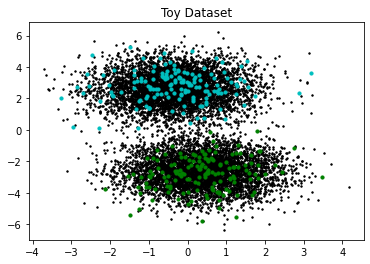

In [11]:
# dimension and number of points in our dataset
dim = 2
num = 10000
np.random.seed(423)

# random vector
mu = np.array(np.random.randn(dim)) 
while np.linalg.norm(mu) < 2.3 :    #  ensures that the two set will be separated
    mu = np.array(np.random.randn(dim)) 

# creation of the dataset
set_ = generate_points(num, mu, dim)
grafico = plot_graph(set_)

In [12]:
print(mu)

[-0.36744634  2.64372818]


In [13]:
# divide points in the dataset
know_p1= [i for i in set_ if i[2]==1]   # labeled first set
know_m1 =[i for i in set_ if i[2]==-1]  # labeled second set
notknow = [i for i in set_ if i[2]==0]  # all unlabeled
print("Number of known points in the cluster: ", len(know_p1), "\nNumber of known points in second cluster: ",len(know_m1),"\nTotal number of unknown points: ", len(notknow))

# find the index of points in order to use them in the optimization function
num_l = int(num*0.015)  # percentage of labeled data
lab_points_1 = set_[0:num_l] # extract labeled points
lab_points_2 = set_[int(num/2):int(num/2+num_l)]
lab_points_1 = np.delete(lab_points_1, [2],1)
lab_points_2 = np.delete(lab_points_2, [2],1)
lab_points = np.concatenate((lab_points_1,lab_points_2), axis = 0)
unlab_points_1 = set_[num_l:int(num/2)] # extract unlabeled points
unlab_points_2 = set_[int(num/2+num_l):]
unlab_points_1 = np.delete(unlab_points_1, [2],1)
unlab_points_2 = np.delete(unlab_points_2, [2],1)
unlab_points = np.concatenate((unlab_points_1,unlab_points_2), axis = 0)

print(f'Size of labeled points: {lab_points.shape}')
print(f'Size of unlabeled points: {unlab_points.shape}')

Number of known points in the cluster:  150 
Number of known points in second cluster:  150 
Total number of unknown points:  9700
Size of labeled points: (300, 2)
Size of unlabeled points: (9700, 2)


In [14]:
#weight of our points
[W_lab, W_unlab] = weight_function(lab_points, unlab_points)

#labels
np.shape(lab_points)
labels = np.ones((300,1))
labels[150:] = -1

#target values (in order to calculate the accuracy)
true_values = np.ones((9700,))
true_values[4850:] = -1

In [15]:
#weights for line_search
W_lab_ls, W_unlab_ls = W_lab, W_unlab 
n_lab_p = lab_points.shape[0]
labels_ls = np.ones((n_lab_p,1))
labels_ls[int(n_lab_p/2):] = -1

#specific functions for line_search
def fun_min_ls(unk, W_lab = W_lab_ls, W_unlab= W_unlab_ls, lab=labels_ls):
    
    Y_lab = (lab - unk.T)**2      
    Y_unlab = (unk - unk.T)**2    
    fact_1 = np.sum(W_lab * Y_lab)
    fact_2 = 0.5 * np.sum(W_unlab * Y_unlab)
    
    return fact_1 + fact_2 # loss_value 
 

def grad_ls(y, labels= labels_ls,W= W_lab_ls, W_bar=W_unlab_ls):
    
    g = (2 * np.sum(W * ((-labels) + y.T), axis = 0) + 2 * np.sum(W_bar * ((-y) + y.T), axis = 0))
    
    return g

Test different Optimization methods


In [ ]:
# Test different Optimization methods

#FIXED
print("Optimization Fixed and Gradient Decent")
opt_fix_gd = optimization(W_lab, W_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'fixed', method = "gd", epochs = 70)
print("*************************************************")
print("Optimization Fixed and Random")
opt_fix_ran = optimization(W_lab, W_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'fixed', method = "random", epochs = 700000)
print("*************************************************")
print("Optimization Fixed and Cyclic")
opt_fix_cyc = optimization(W_lab, W_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'fixed', method = 'cyclic', epochs = 70)
print("*************************************************")

#ARMIJO
print("Optimization Armijo and Gradient Descent")
opt_arm_gd = optimization(W_lab, W_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'armijo', method = "gd", epochs = 30)
print("*************************************************")


#EXACT 
print("Optimization Exact and Gradient Descent")
opt_exa_gd = optimization(W_lab, W_unlab,unlab_points.shape[0], labels,true_values, lnsrc = 'exact', method = "gd", epochs = 30) 
print("*************************************************")


Optimization Fixed and Gradient Decent
Epoch: 0, loss: 345853.2748, accuracy: 0.50567
Epoch: 10, loss: 222732.746, accuracy: 0.930412
Epoch: 20, loss: 198897.1346, accuracy: 0.980825
Epoch: 30, loss: 179552.5129, accuracy: 0.989691
Epoch: 40, loss: 162691.6613, accuracy: 0.992784
Epoch: 50, loss: 147804.9841, accuracy: 0.994124
Epoch: 60, loss: 134601.5185, accuracy: 0.994845
Epoch: 70, loss: 122865.547303, accuracy: 0.994742
*************************************************
Optimization Fixed and Random
Epoch: 0, loss: 345853.2748, accuracy: 0.50567
Epoch: 10000, loss: 308596.4062, accuracy: 0.543402
Epoch: 20000, loss: 284195.0901, accuracy: 0.597732
Epoch: 30000, loss: 267753.8309, accuracy: 0.664742
Epoch: 40000, loss: 255858.2534, accuracy: 0.728144
Epoch: 50000, loss: 247082.6779, accuracy: 0.780309
Epoch: 60000, loss: 240333.5566, accuracy: 0.826495
Epoch: 70000, loss: 235094.6543, accuracy: 0.864948


**Plots functions**

In [ ]:
def produce_plot(opt, method,flag):

  epochs = len(opt[1])
  cputime = opt[2][-1]
  losses = opt[1]
  if method == 'random':
    times = opt[2][0::10000]
    epochs = len(times)*10000
  else: times = opt[2]
  accuracies = opt[3]
  v_x =  np.array(accuracies)
  if flag:
    v_x = v_x > 0.99
    sps = 2
  else:
    v_x = v_x > 0.95
    sps = 0.5
  v_x = np.where(v_x)[0][0]
  fig, axes = plt.subplots(1, 2, figsize = (14,7))
  fig.suptitle('Method = '+ method +'  Ephocs = ' + str(epochs), fontsize=20)
  leg_1 = ['Accuracy = ' + str(round(accuracies[-1], 4)), 'CPU time = ' + str(round(times[-1],4))]
  leg_2 = ['Loss = ' + str(round(losses[-1], 4)), 'CPU time = ' + str(round(times[-1],4))]  
  handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 3
  axes[0].legend(handles,leg_2, loc = 'best', fontsize = 14)
  axes[1].legend(handles,leg_1, loc = 'best', fontsize = 14)
  axes[0].set_xlabel('Time', fontsize = 15)
  axes[1].set_xlabel('Time', fontsize = 15)
  axes[0].set_ylabel('Loss', fontsize = 15)
  axes[1].set_ylabel('Accuracy', fontsize = 15)
  axes[0].plot(times,losses)
  axes[1].plot(times,accuracies)
  axes[1].text(times[v_x]+sps, 0.9, 'Epochs = ' + str(v_x), bbox=dict(fill=False, edgecolor='black', linewidth=1))
  axes[1].text(times[v_x]+sps, 0.885, 'CPU time = ' + str(round(times[v_x],3)), bbox=dict(fill=False, edgecolor='black', linewidth=1))
  axes[1].vlines(times[v_x],0,1,colors='red', linestyles=':')
  plt.ylim(0.8,1)
  plt.rc('xtick',labelsize=12)
  plt.rc('ytick',labelsize=12)
  

In [ ]:
def produce_all_plot_loss(opt_gd, opt_cy, opt_rnd):
  plt.figure()
  plt.plot(opt_gd[2], opt_gd[1])
  plt.plot(opt_cy[2], opt_cy[1])
  plt.plot(opt_rnd[2][0::10000], opt_rnd[1])
  plt.legend(['GD','Cyclic','Random'])
  plt.xlabel('Time')
  plt.ylabel('Loss')
  plt.title('Time-Loss comparison between different methods')
  plt.show()



In [ ]:
def produce_all_plot_acc(opt_gd, opt_cy, opt_rnd, flag):
  plt.figure()

  plt.figure()
  plt.plot(opt_gd[2], opt_gd[3], label = 'GD')
  plt.plot(opt_cy[2][:300], opt_cy[3][:300], label = 'Cyclic')
  plt.plot(opt_rnd[2][0::10000], opt_rnd[3], label = 'Random')
  
  plt.legend()
  axes = plt.gca()
  axes.set_ylim([0.55,1.02])
  if flag:
    axes.set_xlim([0,100])

  plt.xlabel('Time')
  plt.ylabel('Accuracy')
  plt.title('Time-Accuracy comparison between different methods')
  plt.show()

In [ ]:
produce_plot(opt_fix_gd, 'Gradient Descent - Fixed Stepsize',1)
plot_err(opt_fix_gd, true_values, set_, 'Gradient Descent - Fixed Stepsize')

In [ ]:
produce_plot(opt_fix_ran, 'random',1)
plot_err(opt_fix_ran, true_values, set_, 'Random - Fixed Stepsize')

In [ ]:
produce_plot(opt_fix_cyc, 'Cyclic - Fixed Stepsize',1)
plot_err(opt_fix_cyc, true_values, set_, 'Cyclic - Fixed Stepsize')

In [ ]:
produce_plot(opt_arm_gd, 'Gradient Descent - Armijo Rule',1)
plot_err(opt_arm_gd, true_values, set_, 'Gradien Descent - Armijo Rule')

In [ ]:
produce_plot(opt_exa_gd, 'Gradient Descent - Exact line search',1)
plot_err(opt_exa_gd, true_values, set_, 'Gradien Descent - Exact line search') 

In [ ]:
produce_all_plot_loss(opt_fix_gd, opt_fix_cyc, opt_fix_ran)

In [ ]:
produce_all_plot_acc(opt_fix_gd, opt_fix_cyc, opt_fix_ran, 1)

# Dataset Gender

In [ ]:
# upload the dataset from github
url = 'https://raw.githubusercontent.com/lrdsch/gender_classification/main/gender_classification_v7.csv'
df_gender= pd.read_csv(url)
#long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender are the columns
# classification  Male (1) & Female (-1); we have 7 features + 1 column for classification
df_gender.head()


In [ ]:
# normalize data
n_df_gender=normalize(df_gender)

# create two different dataset
df_male=n_df_gender[n_df_gender["gender"] == "Male"] 
df_female=n_df_gender[n_df_gender["gender"] == "Female"] 

# Male=1 & Female=1
df_male.loc[:,"gender"] = 1
df_female.loc[:,"gender"] = -1

p=0.015 # percentage of labelled data
numero_male=df_male.shape[0]             # number of male
numero_female=df_female.shape[0]         # number of female
p_male=math.ceil(p * numero_male)        # number of labelled male
p_female=math.ceil(p * numero_female)    # number of labelled female
lab_male=df_male.iloc[:p_male,:]         # dataframe of labelled male with label at the end
lab_female=df_female.iloc[:p_female,:]   # dataframe of labelled female with label at the end 
unlab_male=df_male.iloc[p_male:,:]       # dataframe of labelled male with label at the end
unlab_female=df_female.iloc[p_female:,:] # dataframe of UNlabelled female with label at the end
#print(lab_male.shape,lab_female.shape,unlab_male.shape,unlab_female.shape)
#print(df_male.shape,df_female.shape)

# target vectors y_lab e y_unlab, y_unlab required for accuracy 
y_lab_df=pd.concat([lab_male.loc[:,"gender"], lab_female.loc[:,"gender"]])  # column vector (1,...1,-1,...,-1) with 78 entry
y_unlab_df=pd.concat([unlab_male.loc[:,"gender"], unlab_female.loc[:,"gender"]]) # column vector (1,...1,-1,...,-1) with 4925 entry (2462=1 and 2463=-1)

# transform into numpy array 
y_lab_array=np.array(y_lab_df[:])
y_unlab_array=np.array(y_unlab_df[:])
y_lab_array = np.reshape(y_lab_array,(y_lab_array.shape[0],1)) # transpose
y_unlab_array = np.reshape(y_unlab_array,(y_unlab_array.shape[0],1)) # transpose

# assign 0 to unlabelled data
unlab_male.loc[:,"gender"]=0
unlab_female.loc[:,"gender"]=0

# creation of the final dataframe containing all the points 
df_final=pd.concat([lab_male, lab_female, unlab_male, unlab_female])

# dataframe of labelled and unlabelled data

df_lab=pd.concat([lab_male,lab_female])
df_unlab=pd.concat([unlab_male,unlab_female])

# transform into numpy array 
array_final=np.array(df_final)
array_lab=np.array(df_lab)
array_unlab=np.array(df_unlab)

num, last= array_final.shape # number of total points (5001) number of features (7)


In [ ]:
# weights for real dataset
W_lab, W_unlab = weight_function(array_lab, array_unlab)

# weights for implement the exact line_search
W_lab, W_unlab = weight_function(array_lab, array_unlab)
W_lab_ls, W_unlab_ls = W_lab, W_unlab 
n_lab_p = array_lab.shape[0]
labels_ls = np.ones((n_lab_p,1))
labels_ls[int(n_lab_p/2):] = -1


In [ ]:
def fun_min_ls(unk, W_lab = W_lab_ls, W_unlab= W_unlab_ls, lab=labels_ls):
    
    Y_lab = (lab - unk.T)**2      
    Y_unlab = (unk - unk.T)**2    
    fact_1 = np.sum(W_lab * Y_lab)
    fact_2 = 0.5 * np.sum(W_unlab * Y_unlab)
    
    return fact_1 + fact_2 # loss_value 
 

def grad_ls(y, labels= labels_ls,W= W_lab_ls, W_bar=W_unlab_ls):
    
    g = (2 * np.sum(W * ((-labels) + y.T), axis = 0) + 2 * np.sum(W_bar * ((-y) + y.T), axis = 0))
    
    return g

In [ ]:
# Test different Optimization methods

#FIXED
print("Optimization Fixed and Gradient Decent")
opt_real_fix_gd = optimization(W_lab, W_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , method= 'gd', rate = 0.0001, epochs = 60, tol = 1e-3,lnsrc="fixed")
print("*************************************************")
print("Optimization Fixed and Random")
opt_real_fix_ran = optimization(W_lab, W_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'fixed', method = "random", epochs = 300000)
print("*************************************************")
print("Optimization Fixed and Cyclic")
opt_real_fix_cyc = optimization(W_lab, W_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'fixed', method = 'cyclic', epochs = 50)
print("*************************************************")

#ARMIJO
print("Optimization Armijo and Gradient Descent")
opt_real_arm_gd = optimization(W_lab, W_unlab, array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'armijo', method = "gd", epochs = 25,rate = 0.0001)
print("*************************************************")


#EXACT 
print("Optimization Exact and Gradient Descent")
opt_real_exa_gd = optimization(W_lab, W_unlab,array_unlab.shape[0], y_lab_array, y_unlab_array , lnsrc = 'exact', method = "gd", epochs = 25)
print("*************************************************")

In [ ]:
produce_plot(opt_real_fix_gd, 'Gradient Descent - Fixed Stepsize',0)

In [ ]:
produce_plot(opt_real_fix_ran, 'random',0)

In [ ]:
produce_plot(opt_real_fix_cyc, 'Cyclic - Fixed Stepsize',0)

In [ ]:
produce_plot(opt_real_arm_gd, 'Gradient Descent - Armijo Rule',0)

In [ ]:
produce_plot(opt_real_exa_gd, 'Gradient Descent - Exact line search',0)

In [ ]:
produce_all_plot_loss(opt_real_fix_gd, opt_real_fix_cyc, opt_real_fix_ran)

In [ ]:
produce_all_plot_acc(opt_real_fix_gd, opt_real_fix_cyc, opt_real_fix_ran,0)